In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity

In [2]:
def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2


def compute_jaccar_simlarity(matrix1, matrix2):

    def replace_with_one(x):
        return 1 if x >= 1 else x

    matrix1_1 = matrix1.applymap(replace_with_one)
    matrix2_1 = matrix2.applymap(replace_with_one)

    score = jaccard_score(matrix1_1.to_numpy(), matrix2_1.to_numpy(), average='weighted')
    weighted_score = weighted_jaccard_similarity(matrix1, matrix2)

    return score, weighted_score


In [3]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

edge1 = pd.read_csv('../networks/matrix/global_weighted.csv', index_col=[0])
edge1 = edge1[['source', 'target', 'weight']]

edge2 = pd.read_csv('../networks/matrix/non_europe_before_1700.csv', index_col=[0])
edge2 = edge2[['source', 'target', 'weight']]


matrix1, matrix2 = prepare_edge_list(edge1, edge2)

#score = jaccard_score(matrix1.to_numpy(), matrix2.to_numpy(), average='weighted')
matrix1, matrix2  = matrix1.to_numpy(), matrix2.to_numpy()

import numpy as np
from scipy.spatial import distance


# Compute distances
euclidean_distance = distance.euclidean(matrix1.flatten(), matrix2.flatten())
manhattan_distance = distance.cityblock(matrix1.flatten(), matrix2.flatten())
cosine_distance = distance.cosine(matrix1.flatten(), matrix2.flatten())
jaccard_distance = distance.jaccard(matrix1.flatten(), matrix2.flatten())


In [4]:
import glob


main_path = '../networks/matrix/'
paths = glob.glob(f'{main_path}*')



datasets ={}

for path in paths:

    mat = pd.read_csv(path, index_col=[0])
    name = path.split(main_path)[1].split('.csv')[0]

    if name in  ['europe_before_1700', 'non_europe_before_1700', 'weighted_optimized_before_1700']:
         datasets[name] = mat

print(list(datasets.keys()))

['europe_before_1700', 'non_europe_before_1700', 'weighted_optimized_before_1700']


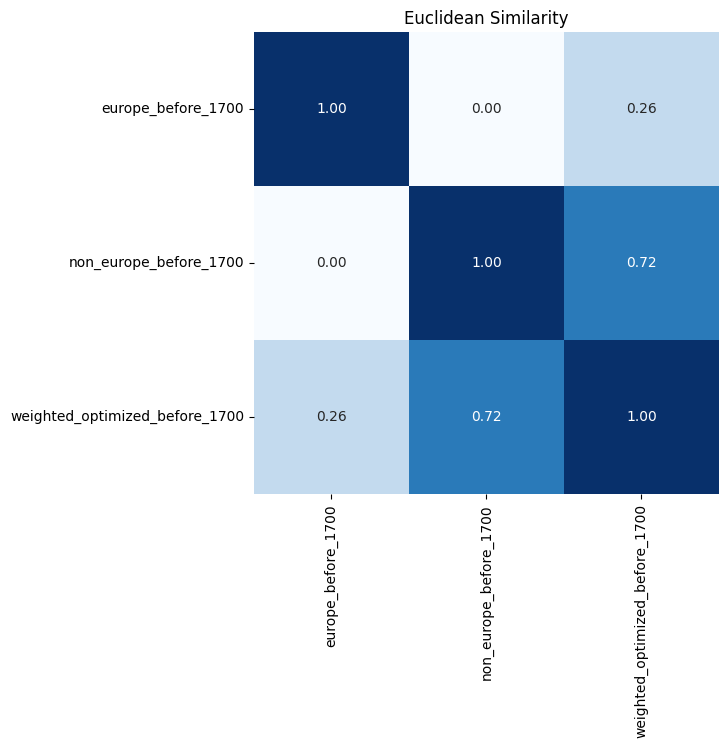

In [5]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = distance.euclidean(matrix1.flatten(), matrix2.flatten())
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
# Scale the entire DataFrame
scaled_df = (matrix_df - matrix_df.min().min()) / (matrix_df.max().max() - matrix_df.min().min())
scaled_df = 1 - scaled_df
plt.figure(figsize=(6, 6))
sns.heatmap(scaled_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Euclidean Similarity')
plt.show()

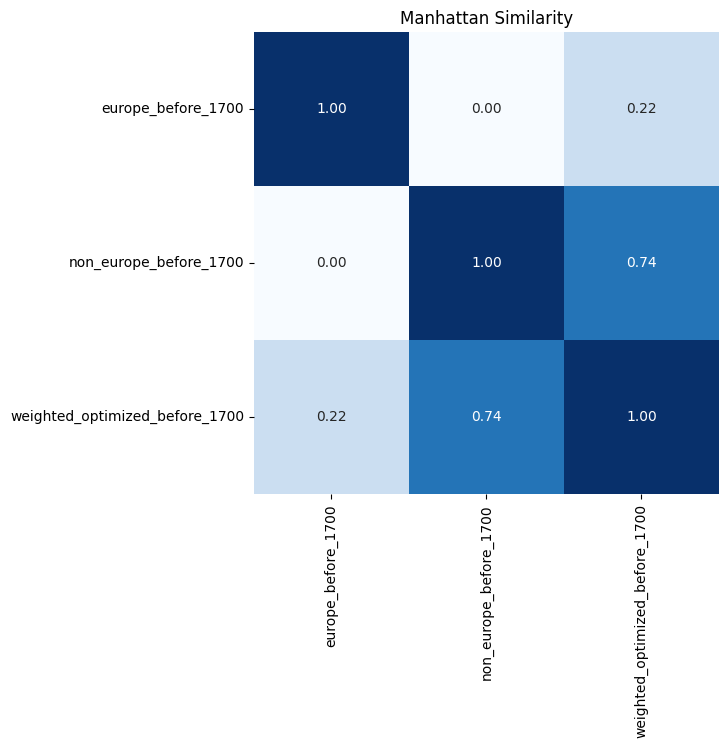

In [6]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = distance.cityblock(matrix1.flatten(), matrix2.flatten())
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
scaled_df = (matrix_df - matrix_df.min().min()) / (matrix_df.max().max() - matrix_df.min().min())
scaled_df = 1 - scaled_df
plt.figure(figsize=(6, 6))
sns.heatmap(scaled_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Manhattan Similarity')
plt.show()
            

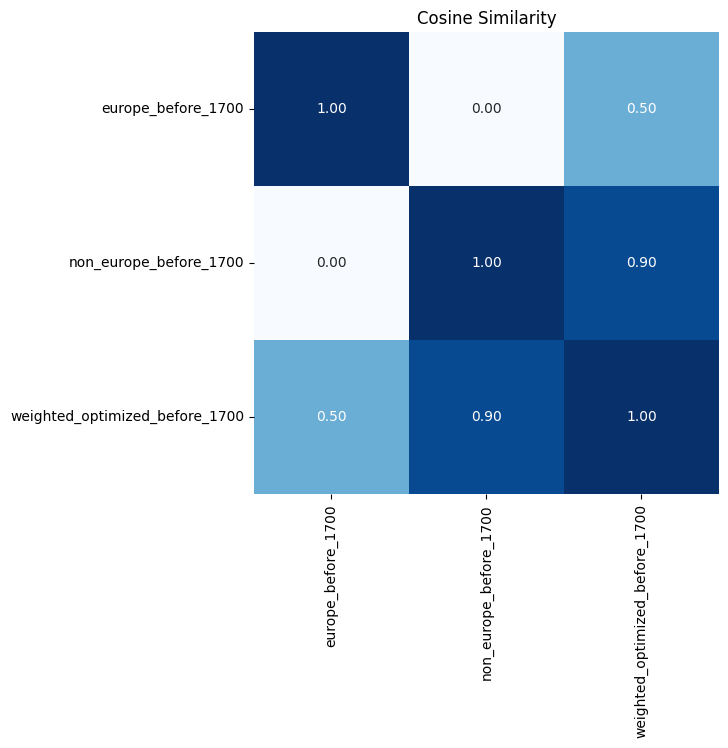

In [7]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
            # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = distance.cosine(matrix1.flatten(), matrix2.flatten())
        score = round(score,2)
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
scaled_df = (matrix_df - matrix_df.min().min()) / (matrix_df.max().max() - matrix_df.min().min())
scaled_df = 1 - scaled_df
plt.figure(figsize=(6, 6))
sns.heatmap(scaled_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Cosine Similarity')
plt.show()

In [8]:
ari_df

,Dataset 1,Dataset 2,metric
0,europe_before_1700,europe_before_1700,0
1,europe_before_1700,non_europe_before_1700,0.1
2,europe_before_1700,weighted_optimized_before_1700,0.05
3,non_europe_before_1700,europe_before_1700,0.1
4,non_europe_before_1700,non_europe_before_1700,0
5,non_europe_before_1700,weighted_optimized_before_1700,0.01
6,weighted_optimized_before_1700,europe_before_1700,0.05
7,weighted_optimized_before_1700,non_europe_before_1700,0.01
8,weighted_optimized_before_1700,weighted_optimized_before_1700,0


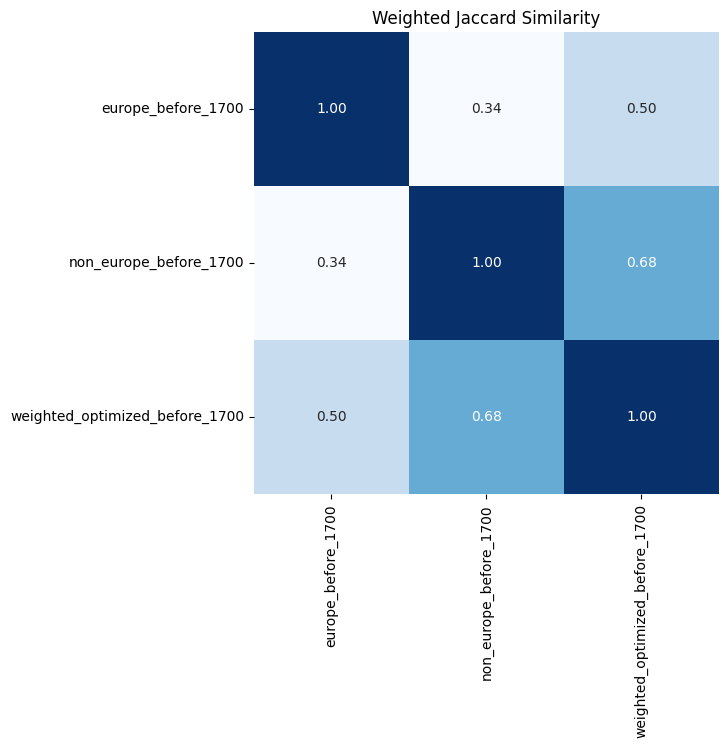

In [9]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
plt.figure(figsize=(6, 6))
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Weighted Jaccard Similarity')

plt.show()
            

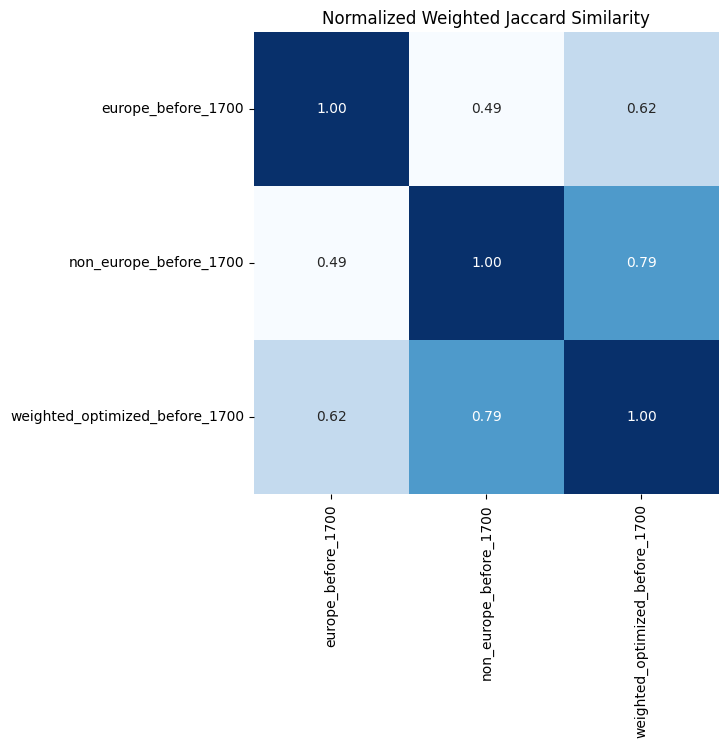

In [10]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
        dataset2 = dataset2[['source', 'target', 'weight']]
        dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
plt.figure(figsize=(6, 6))
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Normalized Weighted Jaccard Similarity')
plt.show()

In [11]:
# global before 1700
# refaire le weighted

# Weighted avec 1700
# 'europe' avant 1700
# non - europe avant 1700
# retirer couleur des clusters (essayer)